In [348]:
# User Input
#    ↓
# Enricher LLM → parses natural language query into smart intent & goal metadata
#    ↓
# Orchestrator LLM → decides what tools to call (MarketDataTool, NewsTool, etc.)
#    ↓
# Parallel Tool Execution (runs only the selected ones)
#    ↓
# Synthesizer LLM → builds final human-readable report
#    ↓
# ✅ Done

#


In [349]:
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


In [350]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="Gemma2-9b-It")

In [399]:
from typing_extensions import TypedDict
from pydantic import BaseModel , Field

class Refined(BaseModel):
    entities : list[str] = Field(description = "entities mentioned if any" )
    intent  : str = Field(description = "intent of the query")
    goal    : str = Field(description = "goal of the query")
    detail_level : str = Field(default="Basic" , description = "detail level what user demands.")
    general_search_query: str = Field(default=None, description="If the query is general, provide a well-phrased search query string to use directly for a general search.")

class ToolToCall(BaseModel):
    name : str = Field( description = "Name of the tool to call" )
    reason : str = Field( description = "contains reason why should this tool be called" )
    called_content : str  # entity name or query

class ToolSchema(BaseModel):
    name: str
    description: str

class ToolCalling(BaseModel):
    tool_call : list[ToolToCall] = Field(default = None)

class MessageState(TypedDict):
    user_query : str
    refined_query : Refined
    tools_to_call : list[ToolToCall]  = Field(default = None)
    content_from_tools : str = Field(default=None)
    report : str

    

In [400]:
from langchain_core.messages import HumanMessage , SystemMessage

def refining_query(state : MessageState):
    prompt = [
        SystemMessage( content = "You are a smart assistant that extracts user intent from stock market related queries." ),
        HumanMessage( content = f"""

        User asked : { state["user_query"] }

        Return structured content in form of :

          entities : entities if mentioned 
          intent  : intent of the query
          goal : goal of the query
          detail_level : detail level what user demands.
          general_search_query: If the user's query is general (like asking about overall market situation), create a polished, complete English search query that could be used directly in a web search.

        """ )
    ]
    structured_llm = llm.with_structured_output(Refined)
    response = structured_llm.invoke(prompt)
    return {"refined_query" : response}
    

In [401]:
input_query = {"user_query" : "Tell me about the Apple and Tesla stock market today , also how is market now days "}
refined_query = refining_query(input_query)
print(refined_query)

{'refined_query': Refined(entities=['Apple', 'Tesla'], intent='informational', goal='get information', detail_level='Basic', general_search_query='current state of the stock market')}


In [402]:
tools_available = [
      ToolSchema(
        name="MarketDataTool",
        description="""
        Use this tool to retrieve current and historical stock performance data (30 days )for a specific company.
        It provides key financial metrics such as stock price, volume, P/E ratio, and market cap—essential for technical 
        analysis, tracking trends, and making informed investment decisions.
        Example: "Get historical stock data for Apple over the past 6 months."
        """
      ),
      ToolSchema(
        name="GeneralSearchTool",
        description="""
        Use this tool for broad, open-ended queries that require general information or exploratory context, 
        especially when the topic isn't limited to a single company. Ideal for understanding market-wide movements, 
        sector trends, macroeconomic updates, or emerging technologies impacting the stock market.
        Example: "How is the stock market performing today?" or "What are the latest trends in AI technology?"
        """
         ),
      ToolSchema(
        name="NewsTool",
        description="""
        Use this tool to retrieve the latest news articles, financial reports, and press releases related to a specific company. 
        It is particularly useful for evaluating current events, earnings announcements, product launches, or regulatory issues 
        that may influence a company's stock performance or market sentiment.
        Example: "Get the latest news about Apple to assess market-moving developments."
        """
       ),
       ToolSchema(
        name="SocialMediaTool",
        description="""
        Use this tool to analyze social media content, trends, and public sentiment related to a specific company, 
        especially in the context of stock market performance. It helps assess how public perception and user-generated 
        posts (e.g., tweets, Reddit threads) might impact investor sentiment, volatility, or trading behavior.
        Example: "Analyze recent social media sentiment around Apple before earnings call."
        """
      )
]

In [403]:
tool_list_text = "\n".join([f"{tool.name}: {tool.description.strip()}" for tool in tools_available])
tool_list_text

'MarketDataTool: Use this tool to retrieve current and historical stock performance data (30 days )for a specific company.\n        It provides key financial metrics such as stock price, volume, P/E ratio, and market cap—essential for technical \n        analysis, tracking trends, and making informed investment decisions.\n        Example: "Get historical stock data for Apple over the past 6 months."\nGeneralSearchTool: Use this tool for broad, open-ended queries that require general information or exploratory context, \n        especially when the topic isn\'t limited to a single company. Ideal for understanding market-wide movements, \n        sector trends, macroeconomic updates, or emerging technologies impacting the stock market.\n        Example: "How is the stock market performing today?" or "What are the latest trends in AI technology?"\nNewsTool: Use this tool to retrieve the latest news articles, financial reports, and press releases related to a specific company. \n        I

In [404]:
def orchestrator(state: MessageState):
    
    prompt = f"""
    
    You are a smart assistant that decides which stock analysis tools to call based on the user's refined query.
    
    ## Refined Query:
    - Entities: {', '.join(state["refined_query"].entities) if state["refined_query"].entities else "None"}
    - General_Search_Query: {state["refined_query"].general_search_query}
    - Intent: {state["refined_query"].intent}
    - Goal: {state["refined_query"].goal}
    - Detail_level: {state["refined_query"].detail_level}
   

    ## Tool List:
    {tool_list_text}

    ## Instructions:
    1. For each entity, determine which tools should be used to fulfill the user's intent and goal. called_content will have the entity name.
    2. Provide a detailed (detail level + what is ultimate goal with this data + reason for analzing data using this tool ) as reason for calling each tool.
    3. If General_Search_Query is not empty , don;t forget to call the GeneralSearchTool and called_content you must have General_Search_Query.

    Return the response output
    
    """

    structured_llm = llm.with_structured_output(ToolCalling);
    response = structured_llm.invoke(prompt)
    print(response)
    
    return {"tools_to_call" : response.tool_call}


In [405]:
content = orchestrator(refined_query)
print(content)


tool_call=[ToolToCall(name='MarketDataTool', reason='Get historical stock data for Apple over the past 30 days to analyze current performance and identify trends.', called_content='Apple'), ToolToCall(name='MarketDataTool', reason='Get historical stock data for Tesla over the past 30 days to analyze current performance and identify trends.', called_content='Tesla'), ToolToCall(name='NewsTool', reason='Retrieve recent news articles about Apple to assess any market-moving developments that could affect its stock price.', called_content='Apple'), ToolToCall(name='NewsTool', reason='Retrieve recent news articles about Tesla to assess any market-moving developments that could affect its stock price.', called_content='Tesla'), ToolToCall(name='SocialMediaTool', reason='Analyze recent social media sentiment around Apple to gauge public perception and identify potential impacts on investor sentiment.', called_content='Apple'), ToolToCall(name='SocialMediaTool', reason='Analyze recent social me

# TOOLS 

SocialMedia Tool

In [406]:
from langchain_community.tools.tavily_search import TavilySearchResults

def SocialMediaTool(entity : str , reason : str) -> str:

    """
    Collect social media posts about a company or entity from platforms like Reddit, Twitter, and StockTwits.
    and summarize it.

    Args   : 
        entity : str
        reason : str
    Return :
        social media content : str
    """

    search_tool = TavilySearchResults(max_results=15)

    results = search_tool.invoke(f"""
                site:reddit.com OR site:twitter.com OR site:stocktwits.com {entity}" 
    """)

    content = []

    for r in results:
        if r.get('content') and len(r.get('content').strip()) > 100:
            content.append(
                {
                    "name" : r.get('title') ,
                    "content" : r.get('content')
                }
            )

    prompt = f"""
    
    You are a skilled financial and social media analyst AI.
    Your task is to analyze recent social media discussions about **"{entity}"** from platforms like Reddit, Twitter, and StockTwits. Focus your analysis specifically on the following objective: **"{reason}"**.

    Use the content to extract meaningful trends, sentiments, and insights that align with the purpose. Identify any key themes, unusual spikes in opinion, recurring concerns, or positive/negative signals that stand out.

    Here are the posts:
    {content}

    Please insightful summary that includes:
    1. Overall sentiment (positive/negative/mixed)
    2. Key themes or concerns discussed
    3. Any influential or viral opinions
    4. Notable bullish/bearish indicators (if financial)
    5. A final concise summary tailored to the given reason

    Be objective, descriptive and insightful.

    """

    response = llm.invoke(prompt)
    # print(response)
    return response.content


In [407]:

socialcontent = SocialMediaTool("Apple" ,"To get the social media image of Apple to have information on impact on its stock")
print(socialcontent)

## Apple Social Media Sentiment Analysis 

Here's a breakdown of recent Apple discussions on social media, focusing on their potential impact on the company's stock:

**1. Overall Sentiment:** Mixed, leaning slightly negative. 

While there is enthusiasm for new products like the Apple TV,  a significant portion of the conversation revolves around criticisms of Apple's practices and perceived lack of innovation.

**2. Key Themes and Concerns:**

* **Software Issues:**  Frustration is evident regarding  uncontrollable autocorrect and  the perceived lack of transparency around Apple's software updates and features.
* **Innovation Gap:**  Users question Apple's recent innovation, comparing iPhones unfavorably to Android devices. 
* **Exclusivity and Limited Hardware Support:**  Concerns are raised about Apple's closed ecosystem and the limitations it imposes on hardware choices.
* **"Apple Intelligence" Misleading Claims:**  Anger and distrust are directed towards Apple over claims about 

GeneralSearch Tool

In [408]:
from langchain_community.tools.tavily_search import TavilySearchResults

def GeneralSearchTool(query : str,reason : str) -> str:

    """
    Perform a general web search to gather broader information on any topic,
    and use an LLM to synthesize a clear summary.

    Args   : 
        entity : str
        reason : str
    Return :
        content : str 
        
    """

    search_tool = TavilySearchResults(max_results=15)

    results = search_tool.run(query)

    content = []

    for r in results:
        if r.get('content') and len(r.get('content').strip()) > 100:
            content.append(
                {
                    "name" : r.get('title') ,
                    "content" : r.get('content')
                }
            )

    prompt = f""" You are a knowledgeable research assistant AI.
     
     The user is searching about: **"{query}"**.
     
     Their purpose for this research is: **"{reason}"**.

        Below are the top search results from the web:

    {content}

    Please analyze and summarize the information in a way that best supports the user's reason. Include:
    1. A focused summary relevant to the reason
    2. Key facts, statistics, and trends
    3. Diverse or opposing viewpoints (if applicable)
    4. Important recent updates (news, events, policies, etc.)
    5. A concise conclusion that helps fulfill the reason

    Be accurate, informative, and aligned with the user’s intent.

    """
        

    response = llm.invoke(prompt)
    # print(response)
    return response.content


In [409]:
GeneralSearchContent = GeneralSearchTool("Hi tell me about curret stock market","The user asked for the current state of the stock market. This tool will provide broad, non-specific information about the current market conditions.")
print(GeneralSearchContent)

The stock market appears to be experiencing a period of volatility and uncertainty.

Here's a summary based on the provided text:

**1. A focused summary relevant to the reason:** The user asked for a broad overview of the current state of the stock market.  The stock market is currently experiencing some uncertainty and volatility, with the Dow Jones, Nasdaq, and S&P 500  are all showing mixed results. 

**2. Key facts, statistics, and trends:**

* The Dow Jones Industrial Average (DJIA) is currently down by 0.99%, while the S&P 500 is down by 0.95%.
* The NASDAQ is also down by 1.30%

**3. Diverse or opposing viewpoints (if applicable): There are mixed signals about the market's direction. Some analysts are optimistic about the market's future, while others are more cautious due to recent events.

**4. Important recent updates (news, events, policies, etc.: The user's question about the stock market comes amid trade tensions and a possible economic slowdown. The Federal Reserve is in

MarketDataTool

In [410]:
import yfinance as yf
from datetime import datetime, timedelta


def MarketData(entity:str , reason : str) -> str:

    """
    Fetch stock prices and financial data for the past 30 days for a specific company or entity.
    and use an LLM to analyze the data based on a given reason.

    Args   : 
        entity : str
        reason : str
    Return :
        Market data content : str
    """
    
    ticker_response = llm.invoke(f"""
        What are the stock ticker symbol for the following company: {entity}?
        If any company doesn't exist, output None for it.
        Return the ticker only with no extra text.
    """)

    ticker = ticker_response.content.strip()
    ticker = ticker.replace("\'", "")

    a = True

    try:
        stock = yf.Ticker(ticker)
        data = stock.history(period="30d")
    except Exception as e:
        a = False
        print("Error occured in MarketData from yfinance")

    if a == False:
        summary = f"No data available for {ticker} ({entity}) over the last 30 days."
    
    else:    
        summary = f"Stock data for {ticker} i.e {entity} over the last 30 days:\n"
        for date,row in data.iterrows():
            date_str = date.strftime("%b %d, %Y")
            open_price = row["Open"]
            close_price = row["Close"]
            volume = row["Volume"]    
            summary += f"Date: {date_str}, Open: ${open_price:.2f}, Close: ${close_price:.2f}, Volume: {volume}\n"

    prompt = f"""
    
    You are a stock market analyst.

    A user is interested in analyzing the recent 30-day performance of {ticker} ({entity}) for the following reason: "{reason}".

    Below is the daily stock data (open, close, volume):

    {summary}

    Please analyze this data to:
    1. Identify any short-term trends or patterns
    2. Mention any volatility or price consistency
    3. Highlight any trading signals or market sentiment
    4. Provide a summary tailored to the user's reason

    Be precise, insightful.
    """

    # Step 5: Run the LLM on the prompt
    response = llm.invoke(prompt)

    return response.content

In [411]:
MarketData("Tesla","Check for signs of growth or weakness before quarterly earnings release")

"## TSLA Stock Analysis: 30-Day Performance\n\nHere's an analysis of TSLA's stock performance over the past 30 days, focusing on potential signs of growth or weakness ahead of the upcoming earnings release:\n\n**1. Short-Term Trends & Patterns:**\n\n* **Initial Surge:**  TSLA experienced a significant upward trend from March 21st to March 26th, gaining substantial value.\n* **Correction:** This was followed by a correction period from March 26th to April 4th, with sharp declines and increased volatility.\n* **Recovery & Consolidation:**  The stock recovered somewhat from the drop, consolidating around the $250-$260 range between April 4th and April 21st.\n* **Recent Upswing:**  TSLA has seen another upward trend since April 22nd, with consistent gains and increasing volume.\n\n**2. Volatility & Price Consistency:**\n\n* **High Volatility:** The past 30 days have been characterized by substantial price swings.  Periods of sharp gains are often followed by corrections, indicating a volat

NewsTool

In [412]:
import requests

os.environ["GNEWS_API_KEY"] = os.getenv("GNEWS_API_KEY")

def NewsTool(entity : str , reason : str) -> str:
    
    """
    Retrieve the latest news headlines related to a company or entity. and
    and use an LLM to analyze and summarize the news based on a specific reason.

    Args   : 
        entity : str
        reason : str 
    Output :
        news related content : str
    """
        
    url = f'https://gnews.io/api/v4/search?q={entity}&lang=en&token={os.environ["GNEWS_API_KEY"]}'
    response = requests.get(url)
    data = response.json()
    if data.get("articles"):
        headlines = [article["title"] for article in data["articles"]]
        content = f"News for {entity}:\n" + "\n".join(headlines) + "\n"
    else:
        content = f"No news found for {entity}.\n"
    

    prompt = f"""
    You are a news analyst AI.
    The user is researching recent news about {entity} with the following reason: "{reason}".

    Here are the latest headlines:

    {content}

    Please provide a summary of the key news trends and insights based on the user's reason. Include:
    1. Relevant trends or developments from the headlines
    2. Sentiment of the news (e.g., positive, negative, neutral)
    3. Key takeaways or potential impacts on the company/market
    4. Concise conclusions or recommendations based on the reason

    Be insightful and structured.
    """

    response = llm.invoke( prompt )

    return response.content


In [413]:
NewsTool("Tesla", "Understand market sentiment ahead of earnings call")

'## Tesla News Analysis: Market Sentiment Ahead of Earnings Call\n\n**1. Relevant Trends and Developments:**\n\n* **Competition:** Headlines highlight intensifying competition in the EV market. GAC\'s Cybertruck rival and the BYD Dolphin review emphasize the emergence of strong players, potentially challenging Tesla\'s market share.\n* **Regulatory Landscape:** The news about relaxed reporting requirements for Level 2 crashes under the Trump administration suggests a potentially less stringent regulatory environment for Tesla, potentially benefiting its production and sales.\n* **Public Perception:** The headlines showcasing negative sentiment towards Elon Musk (honking protest, "Even Tesla drivers seem to hate Elon Musk") and the article questioning Tesla\'s actual state could indicate potential brand and investor concerns.\n* **Focus on Future Technologies:** The article emphasizing the importance of autonomous driving and robotics for Tesla\'s future aligns with the company\'s state

RelativeComparingTool

In [414]:
def RelativeComparisionTool(entity : str) -> str:
    """ 
    Provide a detailed analysis of a company's market position, including comparisons with competitors.
    Args :
        entity : str
    Return : 
        content : str
    """
    content = ""

    return content
    

# AgentCallingTools

In [434]:
def AgentCallingTools(state : MessageState):

    print(state)

    tools = state["tools_to_call"]
    query = state["refined_query"]

    tool_mapping = {
        "MarketDataTool": lambda entity , reason: MarketData(entity , reason),
        "NewsTool": lambda entity , reason :NewsTool(entity , reason),
        "SocialMediaTool": lambda entity , reason: SocialMediaTool(entity , reason),
        "GeneralSearchTool": lambda query , reason: GeneralSearchTool(query , reason),
    }

    content = ""

    if( tools ):
        
        for tool in tools:
            name = tool.name
            reason = tool.reason
            param = tool.called_content

            tool_func = tool_mapping.get(name)

            if tool_func:
                cnt = tool_func(param, reason)
                content = content + cnt
            
    return { "content_from_tools" : content}

In [435]:
tools = [ToolToCall(name='MarketDataTool', reason="Retrieve current stock performance data for Apple to understand its market performance today. This is necessary to fulfill the user's goal of getting basic information about the stock market performance today.", called_content='Apple'), ToolToCall(name='MarketDataTool', reason="Retrieve current stock performance data for Tesla to understand its market performance today. This is necessary to fulfill the user's goal of getting basic information about the stock market performance today.", called_content='Tesla'), ToolToCall(name='NewsTool', reason="Get recent news articles about Apple to understand any events that might be influencing its stock performance today.  This will provide context for the user's request about stock market performance.", called_content='Apple'), ToolToCall(name='NewsTool', reason="Get recent news articles about Tesla to understand any events that might be influencing its stock performance today. This will provide context for the user's request about stock market performance.", called_content='Tesla'), ToolToCall(name='SocialMediaTool', reason='Analyze social media sentiment around Apple to gauge public perception and potential impact on its stock performance today. This will provide insights into market sentiment towards Apple.', called_content='Apple'), ToolToCall(name='SocialMediaTool', reason='Analyze social media sentiment around Tesla to gauge public perception and potential impact on its stock performance today. This will provide insights into market sentiment towards Tesla.', called_content='Tesla')]
AgentCallingTools({ "tools_to_call" : tools , "refined_query" : refined_query["refined_query"]} )

{'tools_to_call': [ToolToCall(name='MarketDataTool', reason="Retrieve current stock performance data for Apple to understand its market performance today. This is necessary to fulfill the user's goal of getting basic information about the stock market performance today.", called_content='Apple'), ToolToCall(name='MarketDataTool', reason="Retrieve current stock performance data for Tesla to understand its market performance today. This is necessary to fulfill the user's goal of getting basic information about the stock market performance today.", called_content='Tesla'), ToolToCall(name='NewsTool', reason="Get recent news articles about Apple to understand any events that might be influencing its stock performance today.  This will provide context for the user's request about stock market performance.", called_content='Apple'), ToolToCall(name='NewsTool', reason="Get recent news articles about Tesla to understand any events that might be influencing its stock performance today. This wil

{'content_from_tools': '## AAPL Stock Performance Analysis (Last 30 Days)\n\nHere\'s an analysis of AAPL\'s stock performance over the past 30 days, tailored to your need for basic information about today\'s market:\n\n**1. Short-Term Trends & Patterns:**\n\n* **Recent Volatility:** AAPL experienced significant volatility in early April, with sharp drops followed by rebounds. This suggests market uncertainty and potential investor nervousness.\n* **Upward Momentum (Late April):** After the volatility, AAPL has shown a more consistent upward trend in late April, closing higher for several consecutive days. This could indicate a return of investor confidence.\n\n**2. Volatility & Price Consistency:**\n\n* **Generally Inconsistent:** The stock has displayed a lack of consistent price movement over the past 30 days. There haven\'t been clear upward or downward trends. \n* **Sharp Fluctuations:**  The stock price experienced notable swings, particularly around April 3rd-10th, indicating hei

# SYNTHESIZER

In [428]:
def synthesizer(state : MessageState) :
   
    prompt = f"""
    You are a top-tier Report Generator AI specialized in transforming structured tool outputs and metadata into polished, human-readable reports.  
    ============================================================
    📥 INPUT DATA:
    ------------------------------------------------------------
    USER QUERY:
    {state["user_query"]}

    REFINED QUERY (Parsed Insight):
    - 🎯 Intent: {state["refined_query"].intent}
    - 🎯 Goal: {state["refined_query"].goal}
    - 🔍 Entities: {state["refined_query"].entities}
    - 📊 Detail Level Requested: {state["refined_query"].detail_level}
    - 🌐 General Search Query (if provided): {state["refined_query"].general_search_query}

    RAW TOOL RESULTS:
    {state["content_from_tools"]}
    ============================================================

    🧠 YOUR TASK:
    Using the information above, generate a high-quality report that fulfills the following:

    ✅ Accurately reflects the user's **intent** and achieves the **goal**  
    ✅ Matches the **requested level of detail** (e.g., high-level summary or deep-dive analysis)  
    ✅ Uses relevant **entities** and context for clarity  
    ✅ Draws from all useful content in the tool output to create insights

    ============================================================    
    📝 REPORT FORMAT GUIDELINES:

    1. ✅ Use **clear section headings** based on the context of the content
    2. ✅ Summarize key points using **bullet points and subheadings**
    3. ✅ Use **emojis** sparingly to enhance readability and structure (not for decoration)
    4. ✅ Maintain **logical flow**, ensuring ideas build on each other clearly
    5. ✅ Avoid generic or vague output — make the report specific, informative, and engaging
    6. ✅ Ensure language is **fluent, professional, and user-focused**


    ============================================================

    📂 For stock analysis-related queries, follow this structure when relevant:
    
    -Company Overview
        - Business summary, market, key offerings
        -💰 Financial Performance
        - Revenue, profit, ratios, trends
    - Stock Performance & Valuation
        - Price movement, valuation, comparison
       
    - Recent News & Developments
        - Key events, updates, regulatory or strategic
        
    - Competitive Landscape
        - Competitors, market position, SWOT highlights

    - Analyst & Market Sentiment
        - Buy/Sell consensus, price targets, insider activity
    
    - Risk Factors
        - Volatility, regulatory, company-specific risks
        
    - Growth Potential & Strategic Outlook
        - Expansion, innovation, future plans
         
    - Summary & Recommendation
        - Overall assessment, suggested action (Buy/Sell/Hold)

============================================================


    🎯 FINAL GOAL:
    Deliver a **structured, polished, and valuable** report that looks as if written by an expert analyst. It should be ready to present or deliver directly to an end user.

    """

    print("hii")
    
    response = llm.invoke(prompt)
    
    return { "report" : response.content }


In [429]:
from langgraph.graph import StateGraph , START , END

graph_builder = StateGraph(MessageState)

graph_builder.add_node("Refining_Query", refining_query)
graph_builder.add_node("Orchestrator", orchestrator)
graph_builder.add_node("Agent_Calling_Tools", AgentCallingTools)
graph_builder.add_node("Synthesizer",synthesizer)

graph_builder.add_edge(START , "Refining_Query")
graph_builder.add_edge("Refining_Query","Orchestrator")
graph_builder.add_edge("Orchestrator","Agent_Calling_Tools")
graph_builder.add_edge("Agent_Calling_Tools","Synthesizer")
graph_builder.add_edge("Synthesizer",END)


graph = graph_builder.compile()


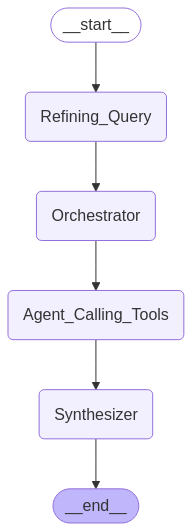

In [430]:
from IPython.display import Image , display

display(Image(graph._draw_graph().draw_mermaid_png()))

In [431]:
response = graph.invoke({"user_query" : "Hey tell me about the current stock market and how is Tesla doing now days "})

tool_call=[ToolToCall(name='MarketDataTool', reason='Retrieve current stock price, volume, P/E ratio and market cap for Tesla to provide basic information on its current state in the stock market.', called_content='Tesla'), ToolToCall(name='NewsTool', reason='Gather recent news articles and press releases related to Tesla to understand any market-moving events or developments that may be influencing its stock performance.', called_content='Tesla'), ToolToCall(name='SocialMediaTool', reason='Analyze social media sentiment towards Tesla to gauge public perception and potential impact on investor sentiment and stock volatility.', called_content='Tesla'), ToolToCall(name='GeneralSearchTool', reason="Obtain a general overview of the current state of the stock market to provide context for Tesla's performance and identify broader market trends.", called_content='current state of the stock market')]
{'user_query': 'Hey tell me about the current stock market and how is Tesla doing now days ', 

In [432]:
print(response.keys())

dict_keys(['user_query', 'refined_query', 'tools_to_call', 'content_from_tools', 'report'])


In [433]:
response["report"].strip()

"## Tesla Stock Analysis: Navigating a Turbulent Market\n\n**🎯  Executive Summary:**\n\nTesla's stock is currently navigating a volatile market environment characterized by both opportunities and challenges. While the broader market has rebounded, uncertainties remain surrounding trade tensions and economic growth.  Tesla's recent performance is a mixed bag, marked by strong upward trends interspersed with periods of consolidation and correction. Understanding the interplay of these factors is crucial for investors seeking to make informed decisions. \n\n**Company Overview** \n\n* Tesla is a leading electric vehicle (EV) and clean energy company known for its innovative technology, high-performance vehicles, and ambitious growth plans.\n*  The company operates in a rapidly evolving industry, facing both fierce competition and evolving consumer preferences.\n\n**💰 Financial Performance:**\n\n* **Recent Stock Performance**: TSLA's stock price has exhibited notable volatility over the pas

In [438]:
import os
print(os.getcwd())


/Users/akashjain/Desktop/AgentVerse/Backend/src/backend/usecase_nb


In [1]:
import sys
sys.path.append('/Users/akashjain/Desktop/AgentVerse/Backend/src/backend')

from graph.Graph_Builder_Stock_Intelligence import Stock_Graph_Builder
from LLMs.groqllm  import GroqLLM


/Users/akashjain/Desktop/AgentVerse/AgentVerse/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
usecase = "StockAI"
obj_llm = GroqLLM()
model = obj_llm.get_llm_model()

In [3]:
graph_builder = Stock_Graph_Builder(model)

In [4]:
graph = graph_builder.setup_graph(usecase)


In [5]:
response = graph.invoke({"user_query" : "Hey tell me about the current stock market and how is Tesla doing now days "})

tool_call=[ToolToCall(name='MarketDataTool', reason="To retrieve Tesla's current stock price, volume, P/E ratio, and market cap. This data is essential for understanding Tesla's current financial health and market position.", called_content='Tesla'), ToolToCall(name='NewsTool', reason="To gather the latest news articles and financial reports related to Tesla. This will help assess any recent events or developments that might be influencing Tesla's stock performance.", called_content='Tesla'), ToolToCall(name='SocialMediaTool', reason='To analyze social media sentiment and trends surrounding Tesla. This will provide insights into public perception and potential investor sentiment towards the company.', called_content='Tesla'), ToolToCall(name='GeneralSearchTool', reason="To get a broad understanding of the current overall performance and trends in the stock market. This will provide context for Tesla's performance.", called_content='current state of the stock market')]
{'user_query': 'H

In [6]:
response["report"].strip()

"## Tesla Stock Overview: Navigating Volatility and Market Headwinds \n\nThis report analyzes Tesla's current stock performance within the context of broader market trends and recent news developments. \n\n**Company Overview** \n* Tesla is a leading electric vehicle (EV) and clean energy company known for its innovative technology, ambitious goals, and disruptive approach to the automotive industry. \n* Tesla's key offerings include electric cars (Model S, 3, X, Y), energy storage systems (Powerwall, Powerpack), and solar energy solutions.\n* The company operates in a rapidly growing but competitive EV market, facing challenges from established automakers and new entrants. \n\n**💰 Financial Performance**\n* Recent data reveals a mixed picture for Tesla's financial performance.  \n    * **Delivery Numbers:**  Tesla's recent deliveries have fallen short of analyst expectations, raising concerns about slowing demand. \n    * **Resale Value:** Used Tesla prices have experienced a significa